## PRACTICAL APPLICATION 17.1 HIERARCHICAL

- Goal: compare the performance of the classifiers (k-nearest neighbors, logistic regression, decision trees, and support vector machines) you encountered in this section of the program.

- Data:
The dataset you will use comes from the UCI Machine Learning repository Links to an external site.. The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns. You can make use of the article Links to an external site.accompanying the dataset (in the .zip file) for more information on the data and features.

- Deliverables:
After understanding, preparing, and modeling your data, build a Jupyter Notebook that includes a clear statement demonstrating your understanding of the business problem, a correct and concise interpretation of descriptive and inferential statistics, your findings (including actionable insights), and next steps and recommendations.

- Business Need: What makes a client apply for a term of deposit

## DATA UNDERSTANDING AND PREP

In [375]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
from datetime import date
from scipy import stats 
filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from sklearn.decomposition import PCA

In [377]:
pip install autoviz


Note: you may need to restart the kernel to use updated packages.


In [378]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [379]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 

X = bank_marketing.data.features 
y = bank_marketing.data.targets 

# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [380]:
# concatenate the dataframes horizontally
bank = pd.concat([X, y], axis=1)

In [381]:
bank.head()

age      job      marital  education  default  balance housing loan  \
0  58     management  married   tertiary    no     2143      yes    no   
1  44     technician   single  secondary    no       29      yes    no   
2  33   entrepreneur  married  secondary    no        2      yes   yes   
3  47    blue-collar  married        NaN    no     1506      yes    no   
4  33            NaN   single        NaN    no        1       no    no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome  y   
0    NaN        5        may     261        1      -1        0       NaN    no  
1    NaN        5        may     151        1      -1        0       NaN    no  
2    NaN        5        may      76        1      -1        0       NaN    no  
3    NaN        5        may      92        1      -1        0       NaN    no  
4    NaN        5        may     198        1      -1        0       NaN    no

In [382]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [383]:
#Change binary objects to numerical for modeling

bank['y'] = bank['y'].map({'yes': 1, "no": 0})
bank['default'] = bank['default'].map({'yes': 1, "no": 0})
bank['housing'] = bank['housing'].map({'yes': 1, "no": 0})
bank['loan'] = bank['loan'].map({'yes': 1, "no": 0})


In [384]:
#change months to numerics 
bank['month'] = bank['month'].map({'may': 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12, "jan": 1, "feb": 2, "mar": 3, "apr": 4})

In [385]:
#X['job'].value_counts() # 11 values, change to steady salary versus not
bank['incomeType'] = bank['job'].map({'blue-collar': "salaried","management": "salaried","technician": "salaried", "admin.": "salaried", "services": "salaried", "self-employed": "variable", "entrepreneur": "variable", "unemployed": "variable", "housemaid": "variable", "student": "variable", "retired": "variable"})


In [387]:
#Create field for total contact time to understand total investment of time for term deposit sale

bank['totalTime'] = bank['campaign'] * bank['duration']
print(bank['totalTime'])

0         261
1         151
2          76
3          92
4         198
         ... 
45206    2931
45207     912
45208    5635
45209    2032
45210     722
Name: totalTime, Length: 45211, dtype: int64


In [388]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  int64 
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  int64 
 7   loan         45211 non-null  int64 
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  int64 
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  int64 
 17  incomeType   44923 non-null  object
 18  totalTime    45211 non-null  int64 
dtypes: int64(13), object(6)
m

In [389]:
bank.describe()

age         default       balance        housing        loan      \
count  45211.000000  45211.000000   45211.000000  45211.000000  45211.000000   
mean      40.936210      0.018027    1362.272058      0.555838      0.160226   
std       10.618762      0.133049    3044.765829      0.496878      0.366820   
min       18.000000      0.000000   -8019.000000      0.000000      0.000000   
25%       33.000000      0.000000      72.000000      0.000000      0.000000   
50%       39.000000      0.000000     448.000000      1.000000      0.000000   
75%       48.000000      0.000000    1428.000000      1.000000      0.000000   
max       95.000000      1.000000  102127.000000      1.000000      1.000000   

        day_of_week      month       duration      campaign        pdays     \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean      15.806419      6.144655    258.163080      2.763841     40.197828   
std        8.322476      2.408034    257.527812      3.098021    100.128746   
min        1.000000      1.000000      0.000000      1.000000     -1.000000   
25%        8.000000      5.000000    103.000000      1.000000     -1.000000   
50%       16.000000      6.000000    180.000000      2.000000     -1.000000   
75%       21.000000      8.000000    319.000000      3.000000     -1.000000   
max       31.000000     12.000000   4918.000000     63.000000    871.000000   

         previous          y         totalTime   
count  45211.000000  45211.000000  45211.000000  
mean       0.580323      0.116985    646.051315  
std        2.303441      0.321406   1094.747093  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000    176.000000  
50%        0.000000      0.000000    344.000000  
75%        0.000000      0.000000    706.000000  
max      275.000000      1.000000  60170.000000

Text(0.5, 1.0, 'Correlation Heatmap Bank Data')

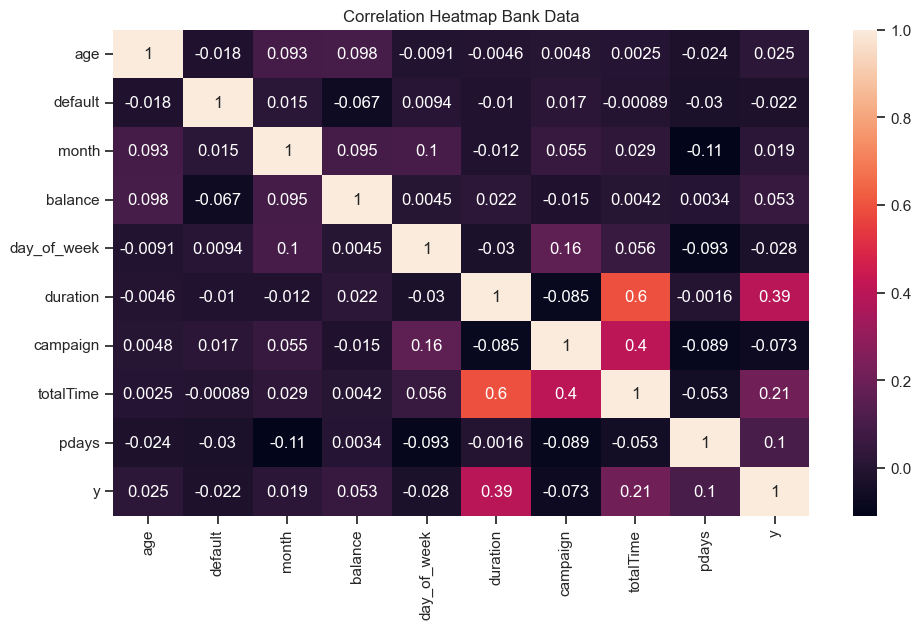

In [390]:
#Explore a correlation of price with age, odometer, transmissions and fuel types
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(bank[['age','default', 'month', 'balance', 'day_of_week', 'duration', 'campaign', 'totalTime', 'pdays', 'y']].corr(), annot=True)
heatmap.set_title('Correlation Heatmap Bank Data')

In [391]:
bank.to_csv("bank.csv")

Shape of your Data Set loaded: (45211, 20)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  9
    Number of String-Categorical Columns =  4
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  2
    Number of Numeric-Boolean Columns =  4
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  1
    Number of Columns to Delete =  0
    20 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['Unnamed: 0']
To fix these data quality issues in the dataset, imp

Number of All Scatter Plots = 45


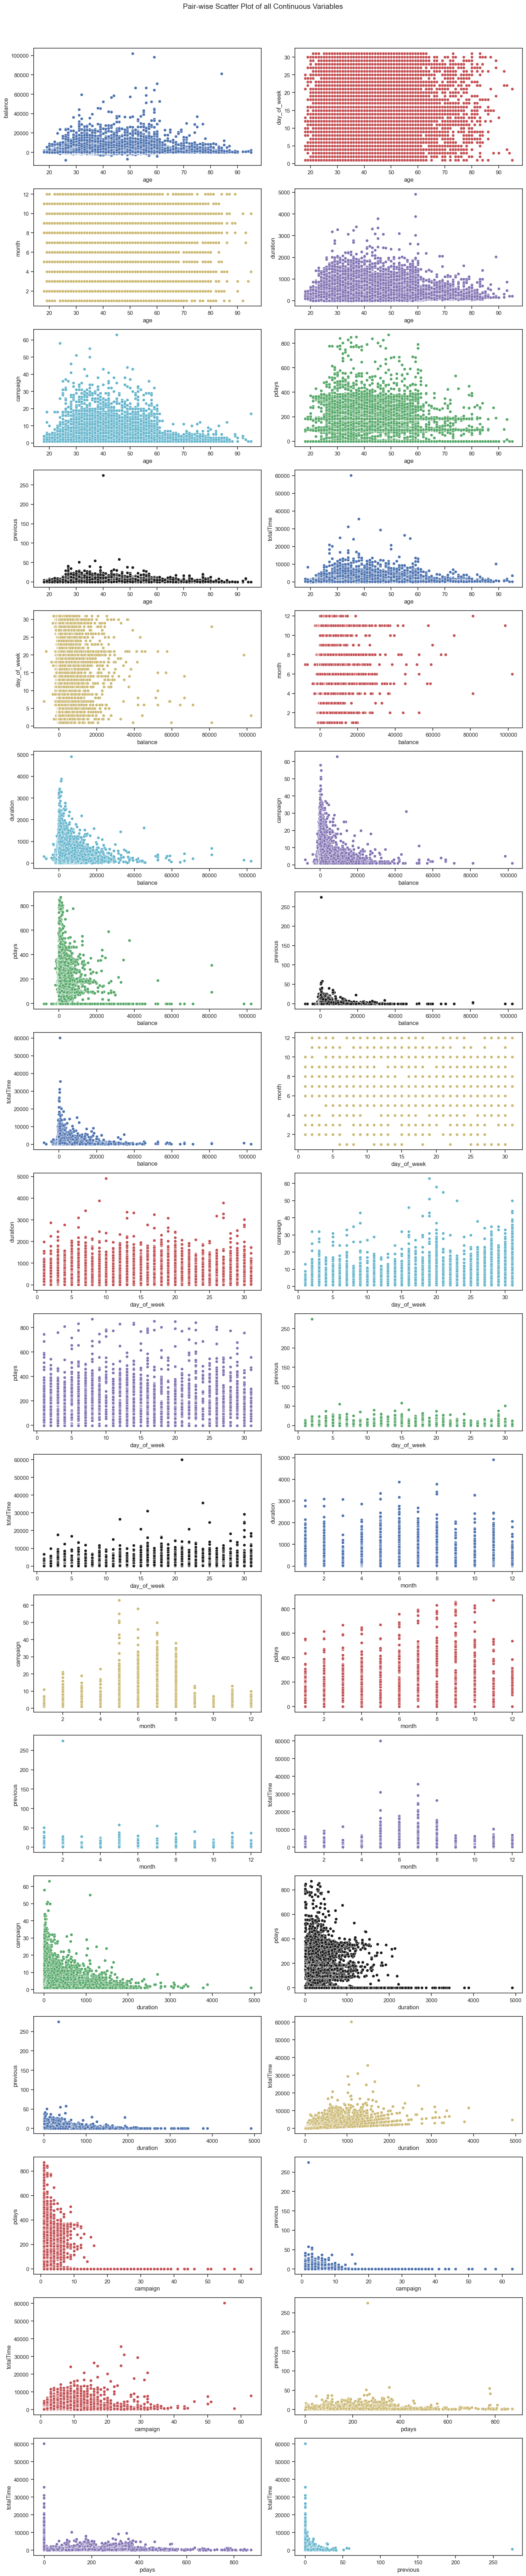

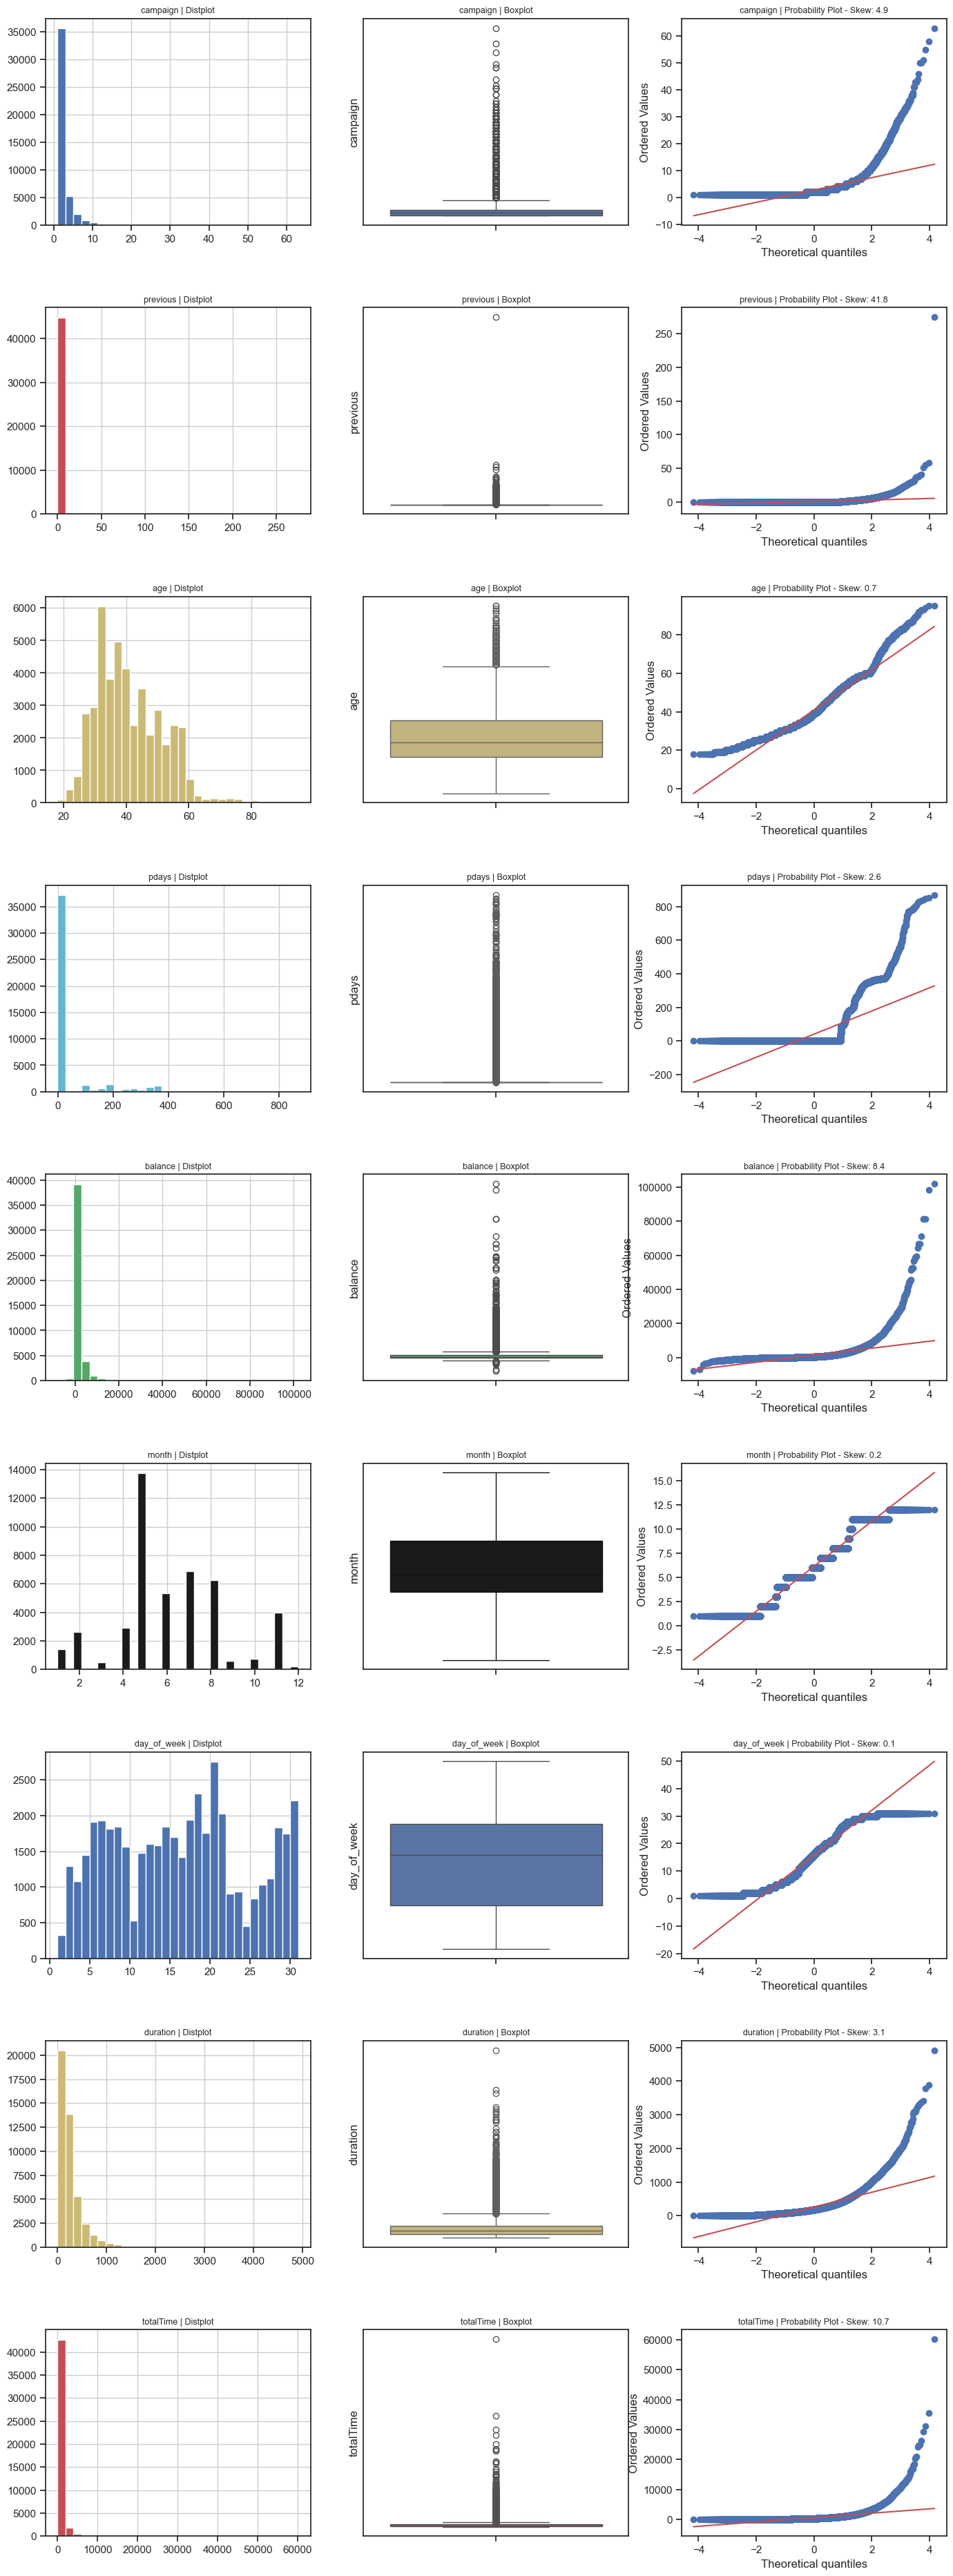

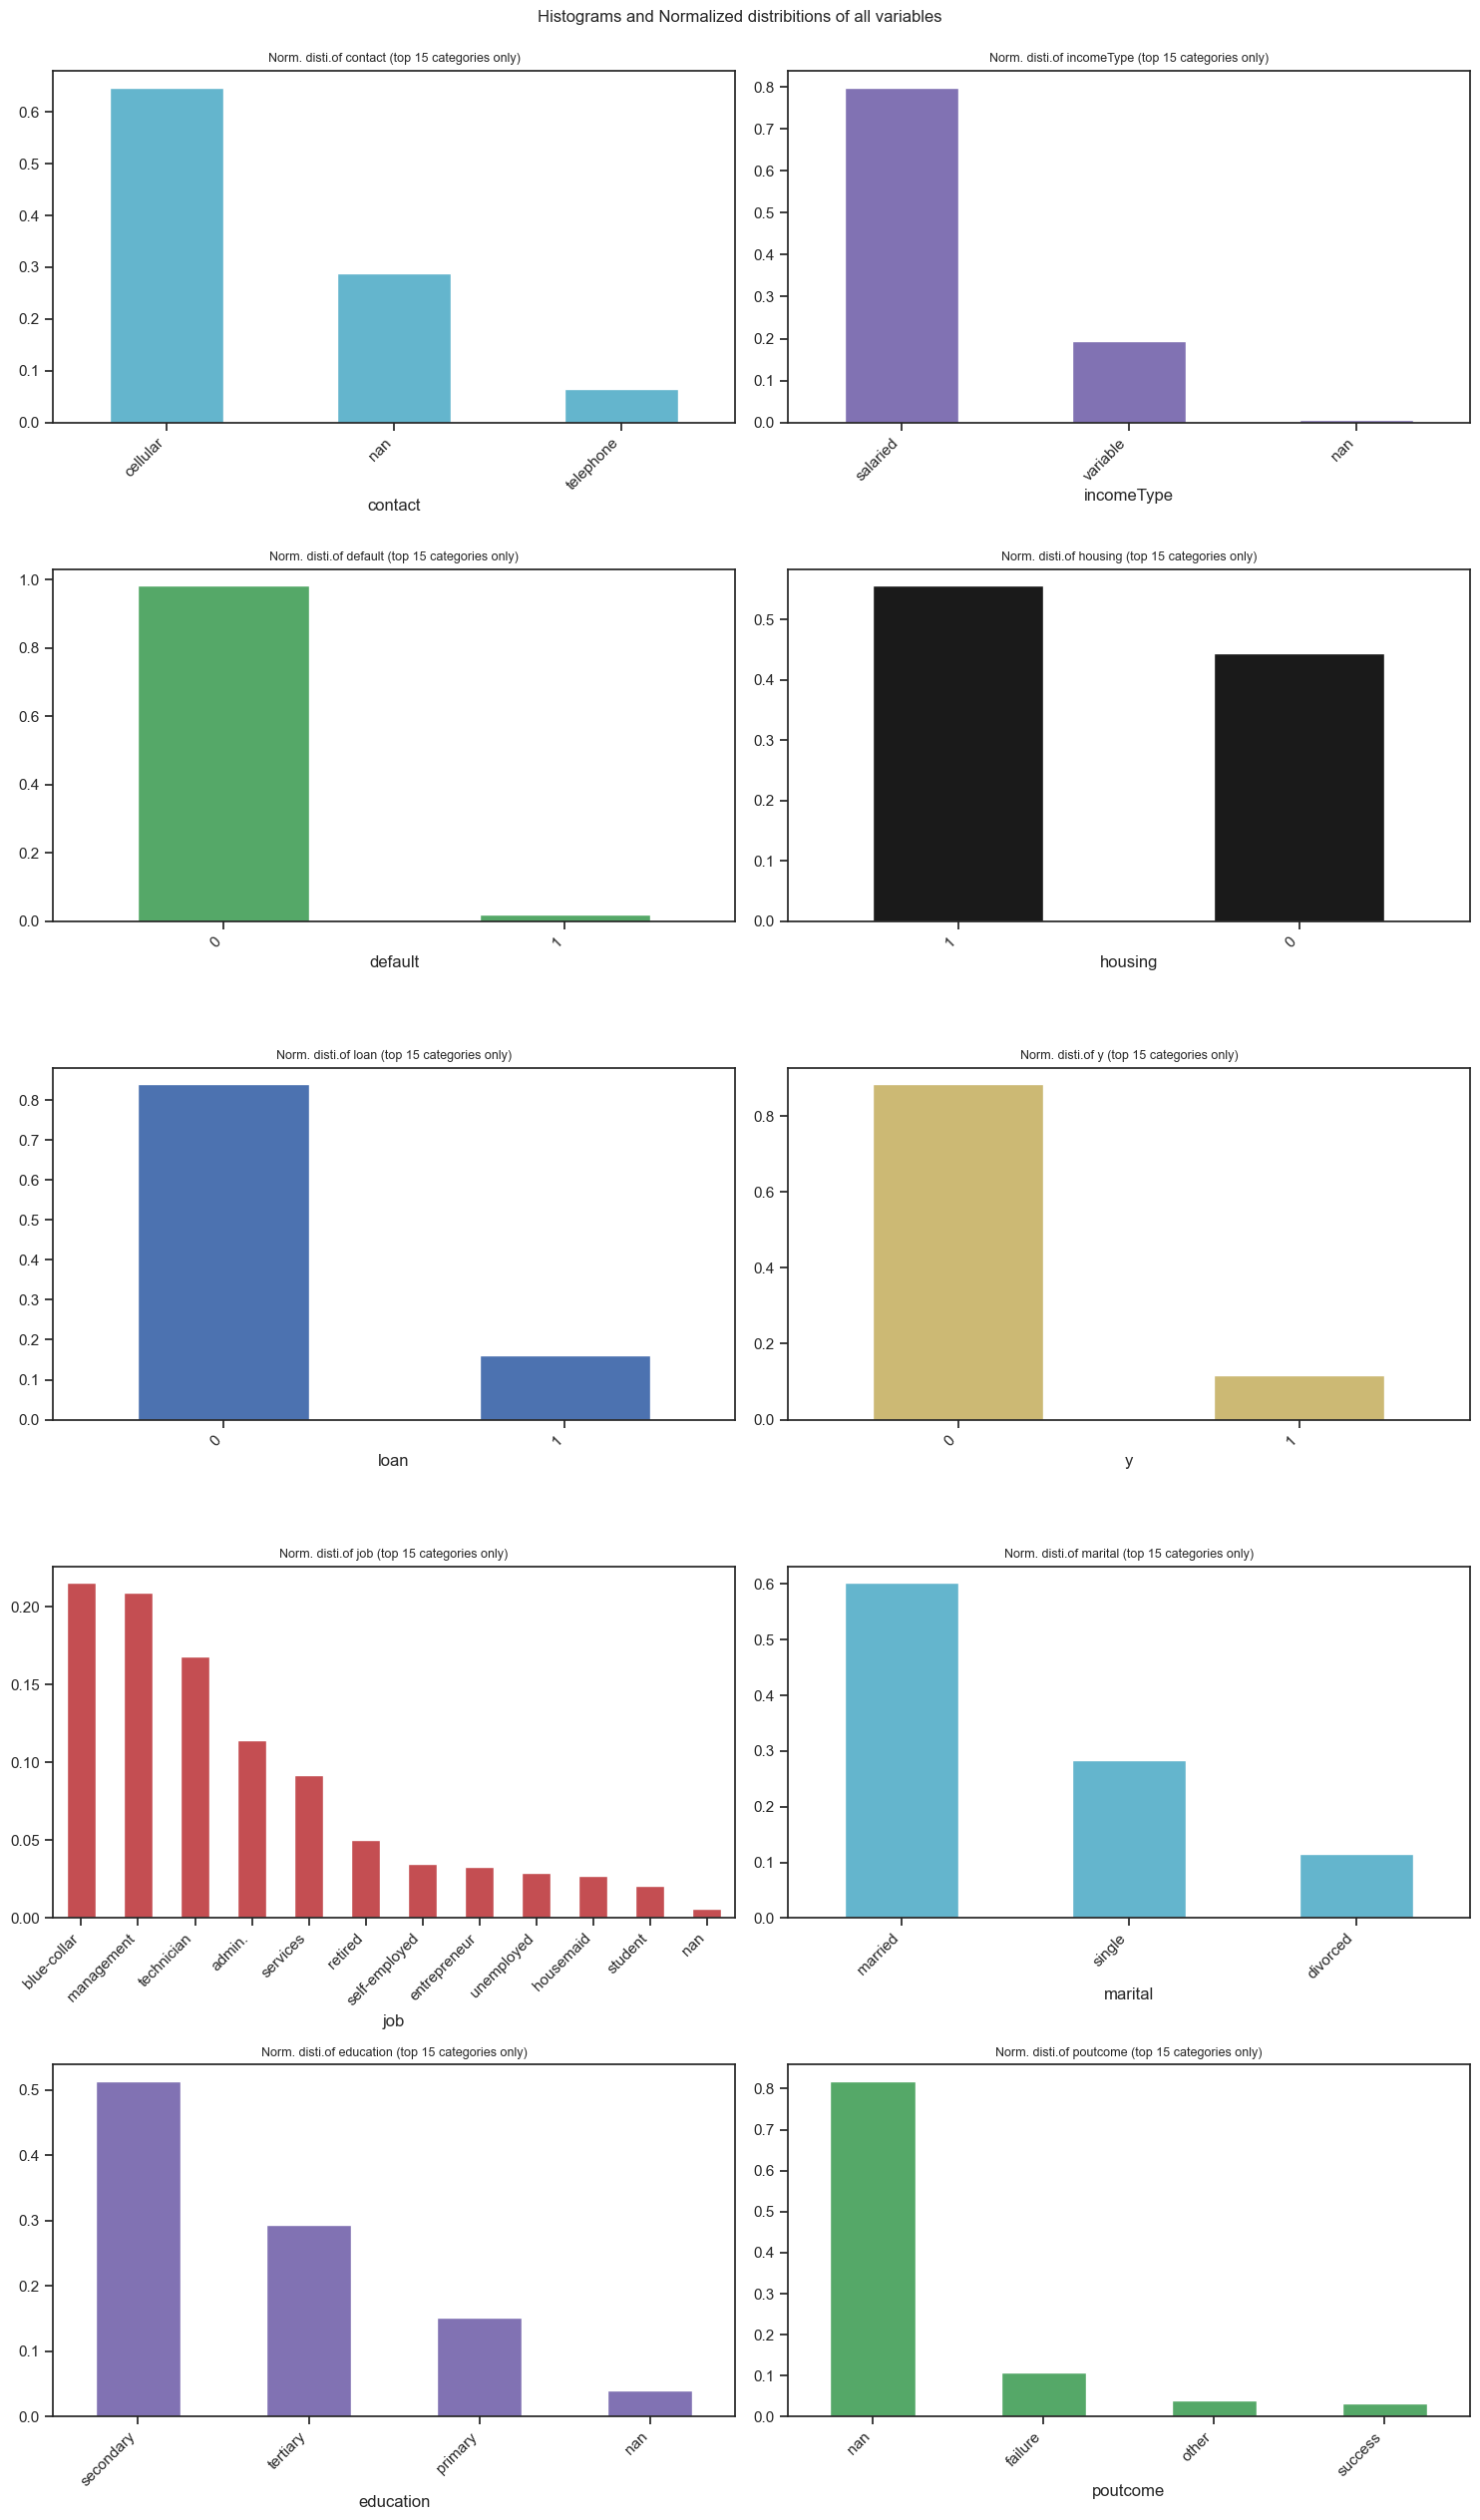

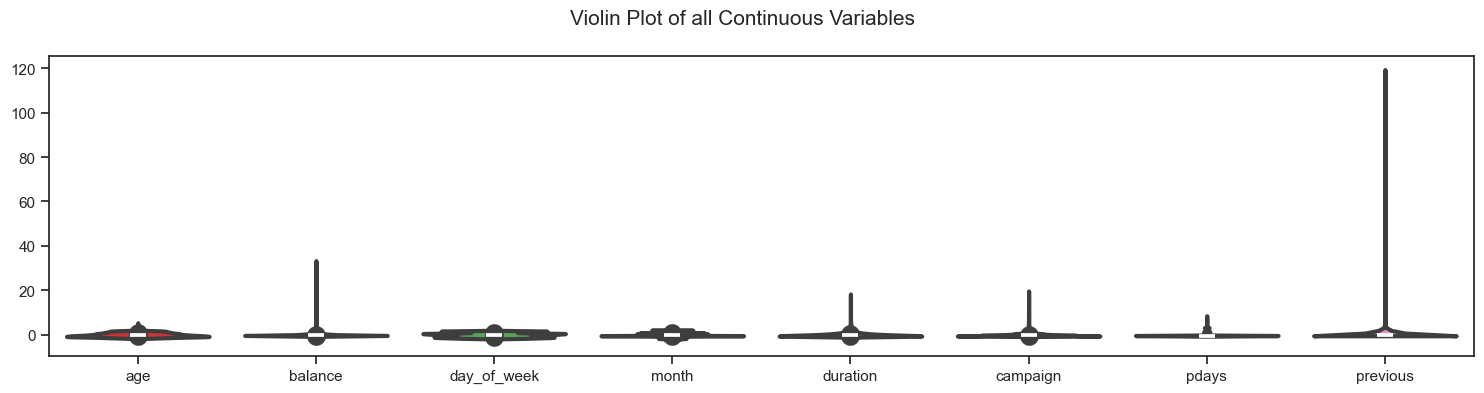

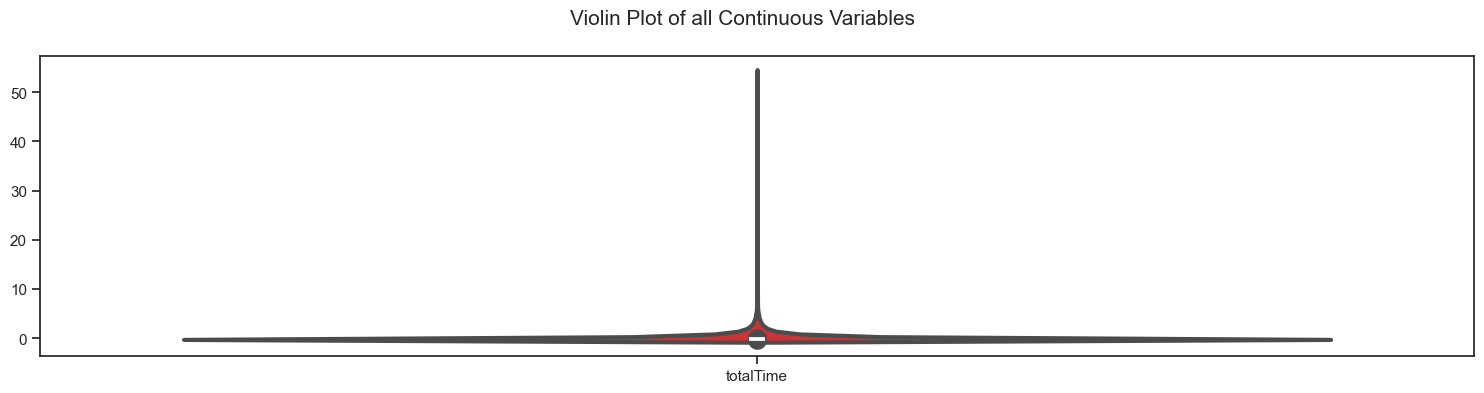

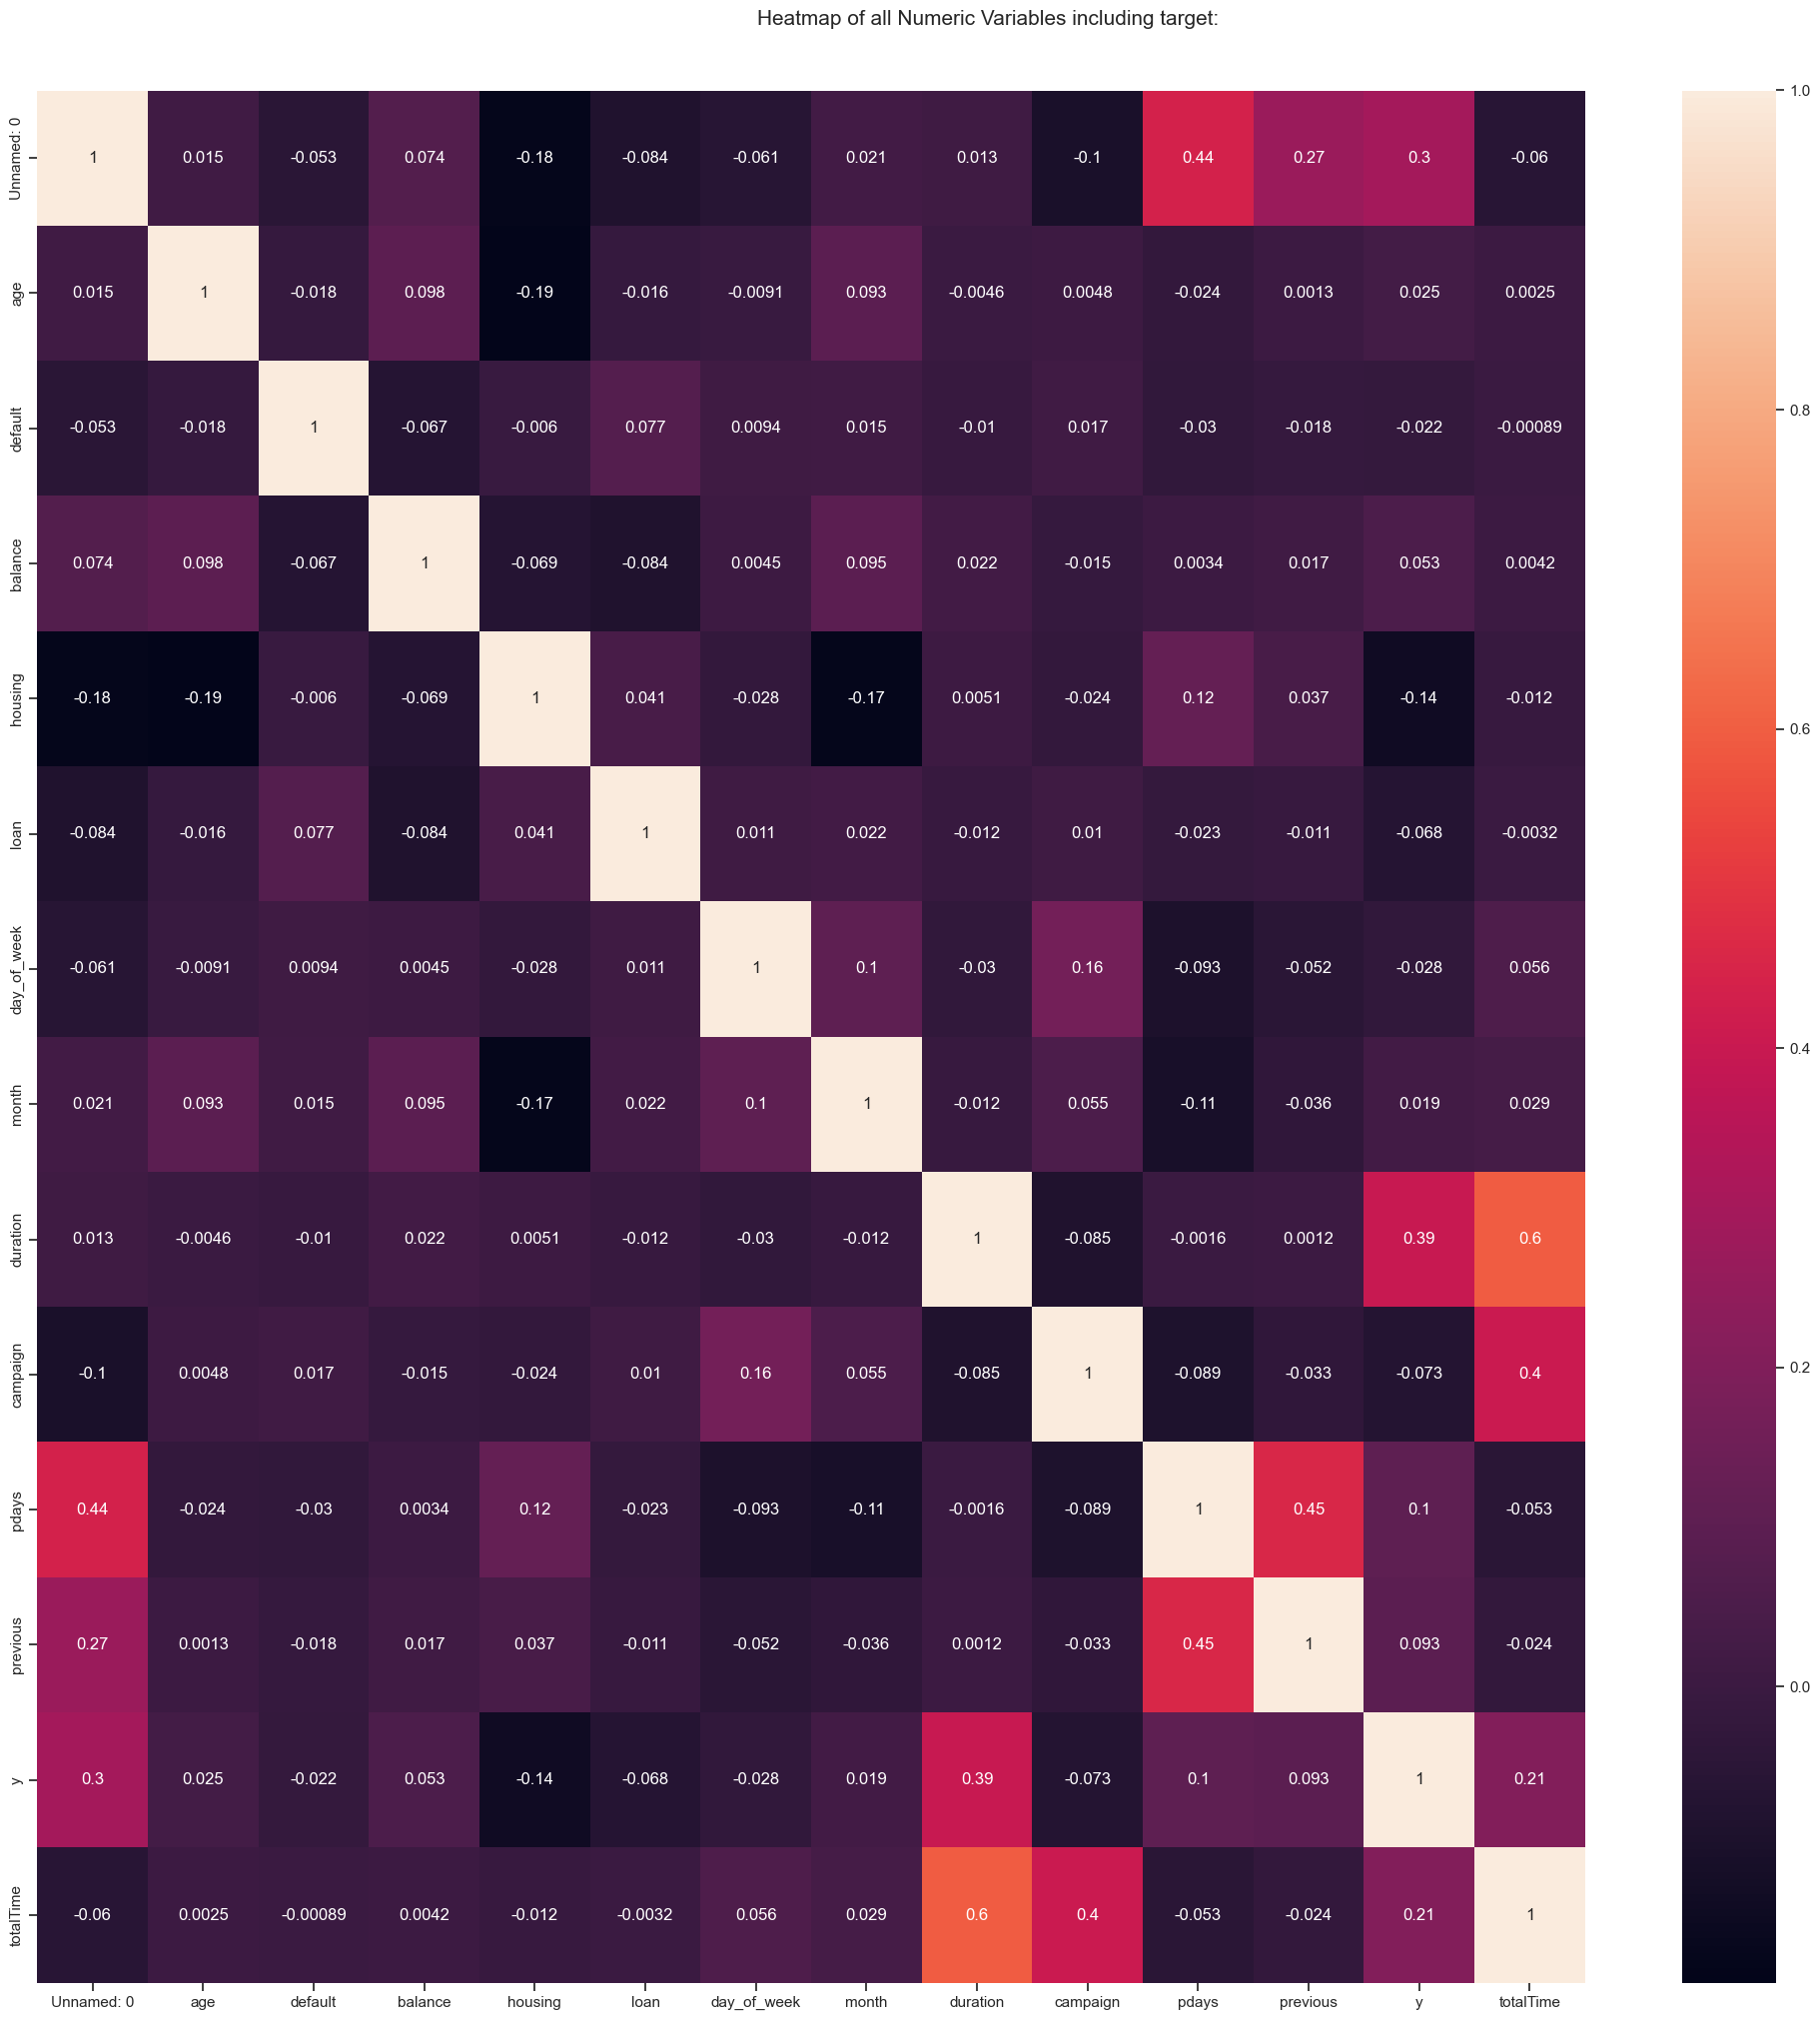

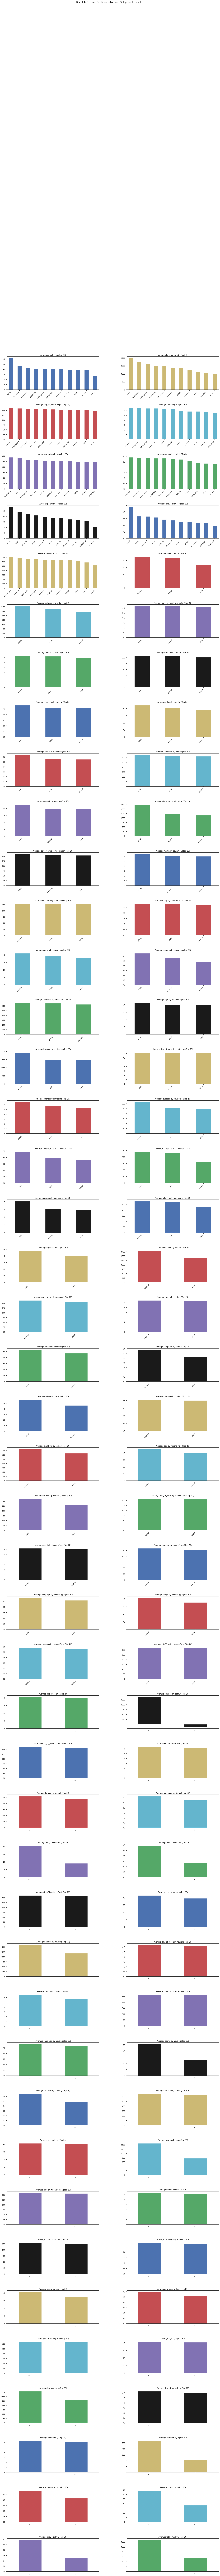

All Plots done
Time to run AutoViz = 18 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [393]:
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline

AV = AutoViz_Class()

viz = AV.AutoViz("bank.csv", sep=",")

In [394]:
#Remove previous outcome as there are not enough non null values
bank = bank.drop(columns= ['poutcome'])

In [395]:
#Remove 815 records at risk of default
bank = bank[bank['default'] != 1]


In [413]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44396 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          44396 non-null  int64 
 1   job          44110 non-null  object
 2   marital      44396 non-null  object
 3   education    42571 non-null  object
 4   default      44396 non-null  int64 
 5   balance      44396 non-null  int64 
 6   housing      44396 non-null  int64 
 7   loan         44396 non-null  int64 
 8   contact      31665 non-null  object
 9   day_of_week  44396 non-null  int64 
 10  month        44396 non-null  int64 
 11  duration     44396 non-null  int64 
 12  campaign     44396 non-null  int64 
 13  pdays        44396 non-null  int64 
 14  previous     44396 non-null  int64 
 15  y            44396 non-null  int64 
 16  incomeType   44110 non-null  object
 17  totalTime    44396 non-null  int64 
dtypes: int64(13), object(5)
memory usage: 6.4+ MB


In [291]:
#Do not remove age outliers greater than 70 to prevent ageism.  

In [415]:
#Categoricals

#X['marital'].value_counts() # 3 values 60, 29, 11 percentage
#X['education'].value_counts() # 3 values, one hot encode
#X['contact'].value_counts() # two values, 64 cellular
bank['job'].value_counts()


job
blue-collar      9531
management       9294
technician       7467
admin.           5097
services         4079
retired          2238
self-employed    1546
entrepreneur     1432
unemployed       1273
housemaid        1218
student           935
Name: count, dtype: int64

In [417]:
#Make Scatter Plots for three categorical and months and yes

In [419]:
#Encode categorical 
bank = pd.get_dummies(bank, columns=['incomeType', 'marital', 'education', 'contact'], drop_first=True)

In [423]:
#scale numerical
scaler=StandardScaler()

bank_scaled = bank
bank_scaled[['age', 'balance', 'duration', 'campaign', 'pdays', 'totalTime']] = scaler.fit_transform(bank[['age', 'balance', 'duration', 'campaign', 'pdays', 'totalTime']])

In [425]:
bank_scaled = bank_scaled.drop(columns= ['job'])

In [427]:
bank_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44396 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  44396 non-null  float64
 1   default              44396 non-null  int64  
 2   balance              44396 non-null  float64
 3   housing              44396 non-null  int64  
 4   loan                 44396 non-null  int64  
 5   day_of_week          44396 non-null  int64  
 6   month                44396 non-null  int64  
 7   duration             44396 non-null  float64
 8   campaign             44396 non-null  float64
 9   pdays                44396 non-null  float64
 10  previous             44396 non-null  int64  
 11  y                    44396 non-null  int64  
 12  totalTime            44396 non-null  float64
 13  incomeType_variable  44396 non-null  bool   
 14  marital_married      44396 non-null  bool   
 15  marital_single       44396 non-null  bool

In [433]:
bank_scaled.head()

age    default   balance  housing  loan  day_of_week  month  duration  \
0  1.601508     0     0.245881     1       0        5         5    0.009632   
1  0.285566     0    -0.444237     1       0        5         5   -0.416334   
2 -0.748389     0    -0.453052     1       1        5         5   -0.706766   
3  0.567554     0     0.037932     1       0        5         5   -0.644807   
4 -0.748389     0    -0.453378     0       0        5         5   -0.234331   

   campaign    pdays   previous  y  totalTime  incomeType_variable  \
0 -0.569089 -0.413961      0     0 -0.350950          False          
1 -0.569089 -0.413961      0     0 -0.451173          False          
2 -0.569089 -0.413961      0     0 -0.519508           True          
3 -0.569089 -0.413961      0     0 -0.504930          False          
4 -0.569089 -0.413961      0     0 -0.408351          False          

   marital_married  marital_single  education_secondary  education_tertiary  \
0        True            False             False                 True         
1       False             True              True                False         
2        True            False              True                False         
3        True            False             False                False         
4       False             True             False                False         

   contact_telephone  
0        False        
1        False        
2        False        
3        False        
4        False

Text(0.5, 1.0, 'Correlation Heatmap Bank Data')

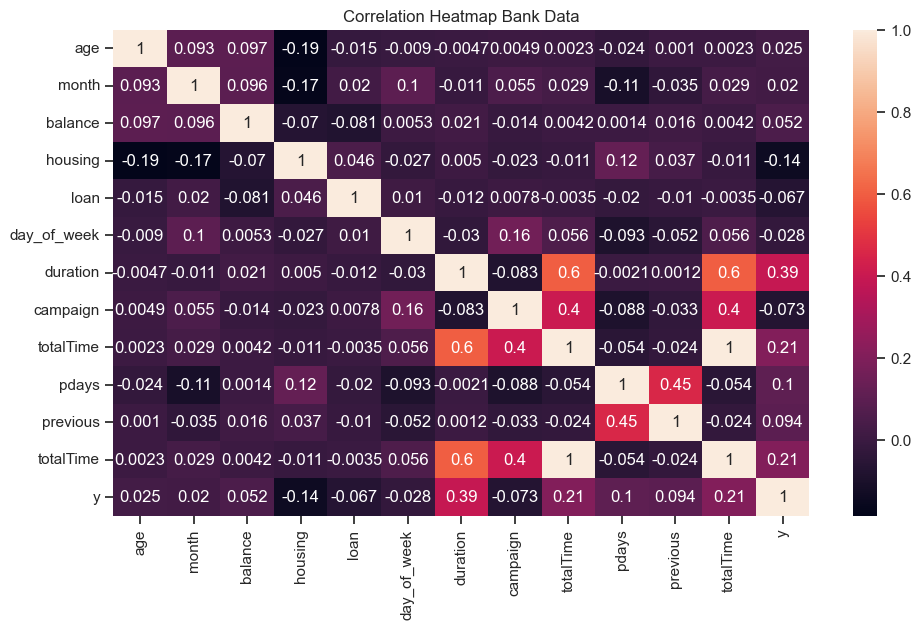

In [435]:
#Explore a correlation of price with age, odometer, transmissions and fuel types
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(bank_scaled[['age','month', 'balance', 'housing', 'loan', 'day_of_week', 'duration', 'campaign', 'totalTime', 'pdays', 'previous', 'totalTime', 'y']].corr(), annot=True)
heatmap.set_title('Correlation Heatmap Bank Data')

## MODELING

In [437]:
#Create Model sets with targets
X = bank_scaled.drop('y', axis=1)
y = bank_scaled['y']

In [439]:
#run lasso to see non zero coef to highlight important features
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': lasso.coef_
})


coef_df.head()

Feature   Coef
0      age   0.0
1  default   0.0
2  balance   0.0
3  housing  -0.0
4     loan  -0.0

In [441]:
#Attempt at SVC that would not run to completion on my system, moved forward to identifying primary components


#%time
#svc = ''
#svc_defaults = ''

#epoch = datetime.datetime.now() 

#svc = SVC().fit(X_train, y_train)
#svc_score_train = svc.score(X_train, y_train)
#svc_score_test = svc.score(X_test, y_test)


#secondTime = datetime.datetime.now() 

# Predict
#y_pred = svc.predict(X_test) 

# Calculate scoring metrics 
#accuracy = metrics.accuracy_score(y_test, y_pred) 
#precision = metrics.precision_score(y_test, y_pred, average='binary') 
#recall = metrics.recall_score(y_test, y_pred, average='binary') 
#f1 = metrics.f1_score(y_test, y_pred, average='binary') 
#conf_matrix = metrics.confusion_matrix(y_test, y_pred) 

#print("Accuracy:", accuracy) 
#print("Precision:", precision) 
#print("Recall:", recall) 
#print("F1 Score:", f1) 
#print("Confusion Matrix:\n", conf_matrix)

#SVC_TotalTime = secondTime-epoch

### ANSWER CHECK
#print(svc_score_train)
#print(svc_score_test)
#print(SVC_TotalTime)

In [443]:
#Create traing and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state = 42)

print("length of X_train:", len(X_train))
print("length of y_train:", len(y_train))
print("length of X_test:", len(X_test))
print("length of y_test:", len(y_test))

length of X_train: 33297
length of y_train: 33297
length of X_test: 11099
length of y_test: 11099


In [447]:
#Scale all variables
X_scaled = scaler.fit_transform(bank_scaled)


In [449]:
#Run principle component analysis to pair down variables
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X_scaled)

In [451]:
print("Components:", pca.components_)

Components: [[-4.60725186e-01  0.00000000e+00 -7.13932489e-02  1.16834678e-01
  -3.57231098e-02 -4.73180747e-02 -1.50800704e-01  4.20557216e-02
  -7.10653582e-02  1.10648190e-01  7.25846747e-02  6.51449080e-02
  -1.96139019e-02 -1.47881839e-01 -5.55374904e-01  5.90869440e-01
   1.53099270e-02  1.15883618e-01 -1.43768762e-01]
 [ 8.56970306e-02 -1.31838984e-16  1.46483269e-01 -2.51770648e-01
  -1.11516264e-01  7.09580904e-02  1.55556991e-01  4.40697149e-01
   1.70400047e-01 -7.70725311e-02 -1.65714868e-02  3.80127299e-01
   4.63084374e-01  1.50154305e-01 -7.44702902e-02  7.64785042e-02
  -3.46503728e-01  3.45759843e-01  6.46270859e-02]]


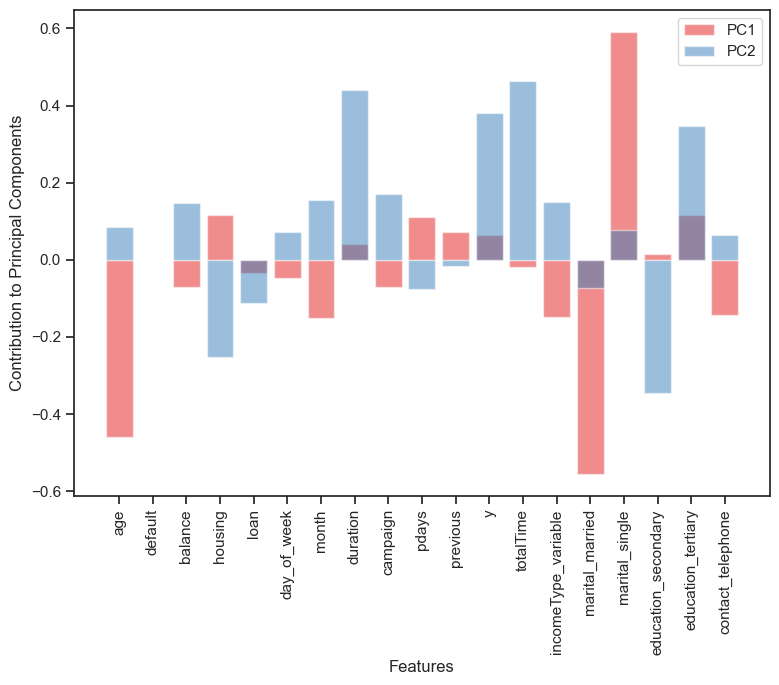

In [455]:
#Plot out components
components = pca.components_ 
plt.figure(figsize=(8,6)) 
plt.bar(range(len(bank_scaled.columns)), components[0], alpha=0.5, align='center', label='PC1') 
plt.bar(range(len(bank_scaled.columns)), components[1], alpha=0.5, align='center', label='PC2') 
plt.xticks(np.arange(len(bank_scaled.columns)), bank_scaled.columns, rotation=90) 
plt.xlabel('Features') 
plt.ylabel('Contribution to Principal Components') 
plt.legend() 
plt.show()


In [457]:
#Review PCA values for all variables

PCA_df = pd.DataFrame(pca.components_, columns=bank_scaled.columns, index=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
print(PCA_df)

        age       default     balance   housing    loan    day_of_week  \
PC1 -0.460725  0.000000e+00 -0.071393  0.116835 -0.035723  -0.047318     
PC2  0.085697 -1.318390e-16  0.146483 -0.251771 -0.111516   0.070958     

       month   duration  campaign    pdays   previous      y     totalTime  \
PC1 -0.150801  0.042056 -0.071065  0.110648  0.072585  0.065145 -0.019614    
PC2  0.155557  0.440697  0.170400 -0.077073 -0.016571  0.380127  0.463084    

     incomeType_variable  marital_married  marital_single  \
PC1      -0.147882          -0.555375         0.590869      
PC2       0.150154          -0.074470         0.076479      

     education_secondary  education_tertiary  contact_telephone  
PC1       0.015310             0.115884          -0.143769       
PC2      -0.346504             0.345760           0.064627       


In [459]:
#Print put PCA for top features

def top_features_for_PCA(PCA_df, n=2):
    top_features = {}
    for pc in PCA_df.index:
        top_features[pc] = PCA_df.loc[pc].abs().nlargest(n).index.tolist()
    return top_features

top_features = top_features_for_PCA(PCA_df)
print("Top Features")
print(top_features)

Top Features
{'PC1': ['marital_single', 'marital_married'], 'PC2': ['totalTime', 'duration']}


In [461]:
#Create reduced data set for modeling based on PCA
bank_reduced = bank_scaled[['age','duration', 'totalTime', 'marital_single', 'marital_married', 'y']]

In [463]:
bank_reduced.head()

age    duration  totalTime  marital_single  marital_married  y
0  1.601508  0.009632 -0.350950        False            True       0
1  0.285566 -0.416334 -0.451173         True           False       0
2 -0.748389 -0.706766 -0.519508        False            True       0
3  0.567554 -0.644807 -0.504930        False            True       0
4 -0.748389 -0.234331 -0.408351         True           False       0

In [465]:
#Create reduced data sets for modeling
X_reduced = bank_reduced.drop('y', axis=1)
y_reduced = bank_reduced['y']

In [467]:
#Split reduced sets into training and test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, 
                                                   random_state = 42)

In [469]:
#Logistic Regression Model with time stamps

# importing time module  
import time  
import datetime
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

%time

lgr = ''
lgr_score = ''
ktrain = ''

    
# Get the epoch  
 
epoch = datetime.datetime.now() 
print("epoch is:", epoch) 

lgr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
lgr_score = lgr.score(X_train, y_train)

newNow = datetime.datetime.now() 
print("Now is:", epoch) 

print(lgr_score)
print(newNow-epoch)

y_pred = lgr.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)

CPU times: total: 0 ns
Wall time: 0 ns
epoch is: 2024-08-24 15:01:04.911319
Now is: 2024-08-24 15:01:04.911319
0.8886085833558579
0:00:00.014640
Accuracy: 0.8858455716731237
Precision: 0.5721649484536082
Recall: 0.16780045351473924
F1 Score: 0.2594973699590883
Confusion Matrix:
 [[9610  166]
 [1101  222]]


In [471]:
#Reran model with a chamged value of C

#Logistic Regression2
%time
lgr2 = ''
lgr_score2 = ''

# importing time module  
import time  
import datetime
    
# Get the epoch  
 
epoch = datetime.datetime.now() 
print("epoch is:", epoch) 

lgr2 = LogisticRegression(solver = 'liblinear', C=0.01).fit(X_train, y_train)
lgr_score2 = lgr.score(X_train, y_train)

newNow = datetime.datetime.now() 
print("Now is:", epoch) 

print(lgr_score2)
print(newNow-epoch)

y_pred = lgr2.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)


CPU times: total: 0 ns
Wall time: 0 ns
epoch is: 2024-08-24 15:01:05.777019
Now is: 2024-08-24 15:01:05.777019
0.8886085833558579
0:00:00.016778
Accuracy: 0.8864762591224434
Precision: 0.5853658536585366
Recall: 0.16326530612244897
F1 Score: 0.2553191489361702
Confusion Matrix:
 [[9623  153]
 [1107  216]]


In [473]:
#Decision Trees with time stamps
%time

dtc = ''
dtc_score = ''

epoch = datetime.datetime.now() 

dtc = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
dtc_score_train = dtc.score(X_train, y_train)
dtc_score_test = dtc.score(X_test, y_test)


secondTime = datetime.datetime.now() 
print("New is:", epoch) 

print(dtc_score_train)
print(dtc_score_test)
print(secondTime-epoch)

y_pred = dtc.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)


CPU times: total: 0 ns
Wall time: 0 ns
New is: 2024-08-24 15:01:06.769197
0.8908910712676817
0.8880980268492658
0:00:00.024960
Accuracy: 0.8880980268492658
Precision: 0.5680672268907563
Recall: 0.25547996976568405
F1 Score: 0.3524504692387904
Confusion Matrix:
 [[9519  257]
 [ 985  338]]


In [475]:
#KNN
%time
knn = ''
knn_score_test = ''
knn_score_train = ''

epoch = datetime.datetime.now() 

### BEGIN SOLUTION
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)
knn_score_train = knn.score(X_train, y_train)
knn_score_test = knn.score(X_test, y_test)

secondTime = datetime.datetime.now() 

print(knn_score_train)
print(knn_score_test)
print(secondTime-epoch)

y_pred = knn.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)

CPU times: total: 0 ns
Wall time: 0 ns
0.8993603027299757
0.8817911523560681
0:00:00.927185
Accuracy: 0.8817911523560681
Precision: 0.5124716553287982
Recall: 0.1708238851095994
F1 Score: 0.2562358276643991
Confusion Matrix:
 [[9561  215]
 [1097  226]]


In [477]:
from sklearn import metrics
from sklearn import svm

epoch = datetime.datetime.now() 
# Train the SVM with linear kernel
clf = svm.SVC(kernel='linear', gamma=2).fit(X_reduced, y_reduced)
secondTime = datetime.datetime.now() 

# Predict
y_pred = clf.predict(X_test) 


# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)

SVC_TotalTime = secondTime-epoch
print(SVC_TotalTime)

Accuracy: 0.8808000720785656
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[9776    0]
 [1323    0]]
0:00:11.849873


In [478]:
#Cross validate the accuracy scores

from sklearn.model_selection import cross_val_score

#Cross Validation
cv_scores = cross_val_score(clf, X_reduced, y_reduced, cv=5)

print("Cross Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross Validation Scores: [0.88198198 0.88208132 0.88208132 0.88208132 0.88196869]
Mean CV Score: 0.8820389237080306


In [479]:
from sklearn import svm
from sklearn import metrics

epoch = datetime.datetime.now() 

#Results had no precision or recall, so I am trying to even out the sample sizes
# Train the SVM with linear kernel and class weights

clf = svm.SVC(kernel='linear', class_weight='balanced', gamma=2).fit(X_reduced, y_reduced)

secondTime = datetime.datetime.now() 



# Predict
y_pred = clf.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)

SVC_Balanced_TotalTime = secondTime-epoch
print(SVC_Balanced_TotalTime)


Accuracy: 0.8016037480854131
Precision: 0.3229963753523963
Recall: 0.6061980347694633
F1 Score: 0.42143983184445605
Confusion Matrix:
 [[8095 1681]
 [ 521  802]]
0:00:38.651761


In [480]:
from sklearn import svm
from sklearn import metrics

epoch = datetime.datetime.now() 

#Results had no precision or recall, so I am trying to even out the sample sizes
# Train the SVM with linear kernel and class weights
clf2 = svm.SVC(kernel='rbf', class_weight='balanced', gamma=2).fit(X_reduced, y_reduced)

secondTime = datetime.datetime.now() 



# Predict
y_pred = clf2.predict(X_test) 

# Calculate scoring metrics 
accuracy = metrics.accuracy_score(y_test, y_pred) 
precision = metrics.precision_score(y_test, y_pred, average='binary') 
recall = metrics.recall_score(y_test, y_pred, average='binary') 
f1 = metrics.f1_score(y_test, y_pred, average='binary') 
conf_matrix = metrics.confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)

SVC_Balanced_TotalTime = secondTime-epoch
print(SVC_Balanced_TotalTime)

Accuracy: 0.7623209298134968
Precision: 0.2989911342097218
Recall: 0.7392290249433107
F1 Score: 0.4257727470613844
Confusion Matrix:
 [[7483 2293]
 [ 345  978]]
0:00:47.314460


In [481]:
from sklearn import svm
from sklearn import metrics

epoch = datetime.datetime.now() 

#Results had no precision or recall, so I am trying to even out the sample sizes
# Train the SVM with linear kernel and class weights
clf3 = svm.SVC(kernel='sigmoid', class_weight='balanced', gamma=2).fit(X_reduced, y_reduced)

secondTime = datetime.datetime.now() 



# Predict
y_pred = clf3.predict(X_test) 

# Calculate scoring metrics 
accuracy = accuracy_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred, average='binary') 
recall = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred) 

print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1 Score:", f1) 
print("Confusion Matrix:\n", conf_matrix)


SVC_Balanced_TotalTime = secondTime-epoch
print(SVC_Balanced_TotalTime)

Accuracy: 0.6004144517524101
Precision: 0.1680887372013652
Recall: 0.5956160241874527
F1 Score: 0.2621859923473632
Confusion Matrix:
 [[5876 3900]
 [ 535  788]]
0:00:39.891241


## EVALUATION 

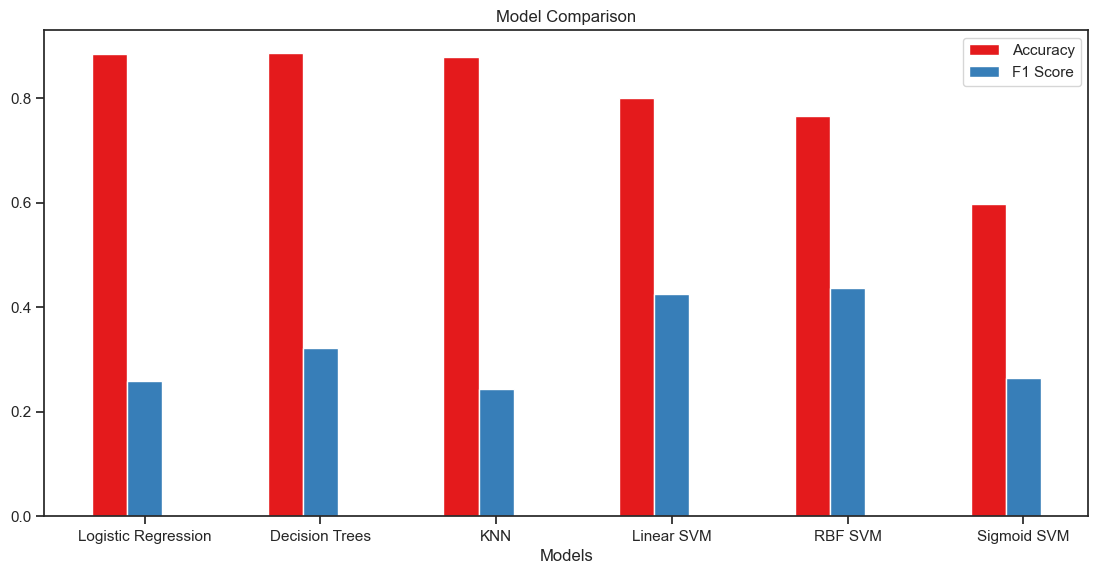

In [516]:
metrics = { 
    'Accuracy': [0.88516, 0.88604, 0.87879, 0.80058, 0.76563,0.59815 ],
    'F1_Score': [0.25913, 0.32281,0.24309, 0.42617, 0.43602, 0.26426  ]
}


models = ['Logistic Regression', 'Decision Trees', 'KNN', 'Linear SVM', 'RBF SVM', 'Sigmoid SVM']

x=np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x-width, metrics['Accuracy'], width, label='Accuracy')
ax.bar(x , metrics['F1_Score'], width, label='F1 Score')

ax.set_xlabel('Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title('Model Comparison')
ax.legend()
plt.show()

In [517]:
#Find feature important for SVM
important_features = clf.coef_.flatten()
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': important_features})
print(importance_df)

      Feature       Importance
0              age   0.187650 
1         duration   1.233415 
2        totalTime  -0.165540 
3   marital_single   0.492596 
4  marital_married  -0.008768 


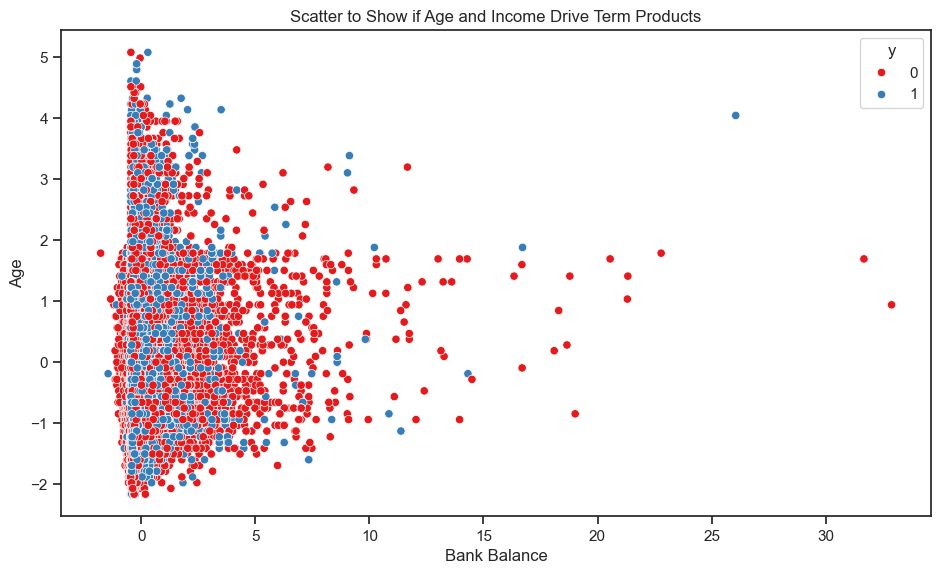

In [511]:
#Chart the relation of age, finance to term products

import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x='balance', y='age', hue='y',data=bank)

plt.xlabel('Bank Balance')
plt.ylabel('Age')
plt.title('Scatter to Show if Age and Income Drive Term Products')
plt.show()

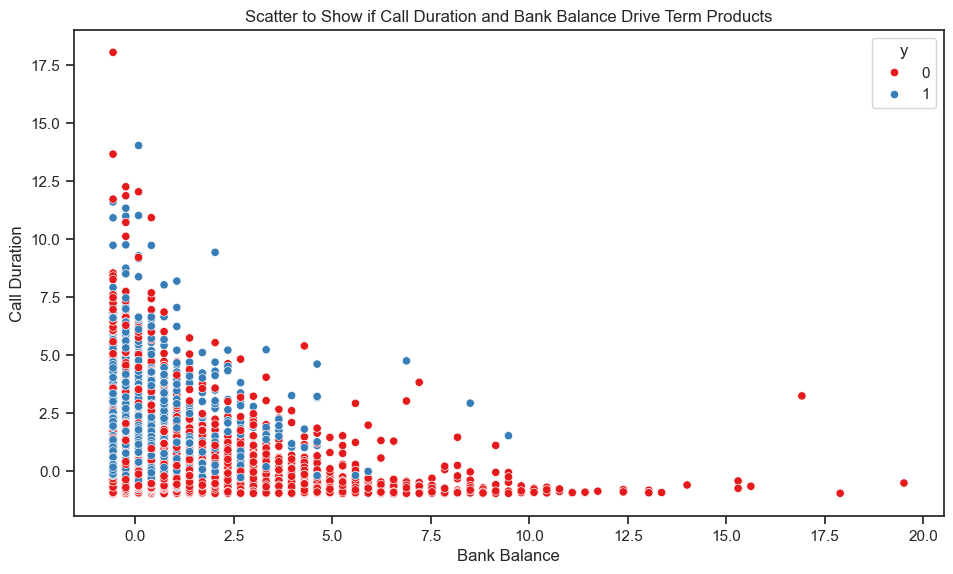

In [513]:
#Chart the relation of age, finance to term products

import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x='campaign', y='duration', hue='y',data=bank)

plt.xlabel('Bank Balance')
plt.ylabel('Call Duration')
plt.title('Scatter to Show if Call Duration and Bank Balance Drive Term Products')
plt.show()

<Figure size 1000x600 with 0 Axes>

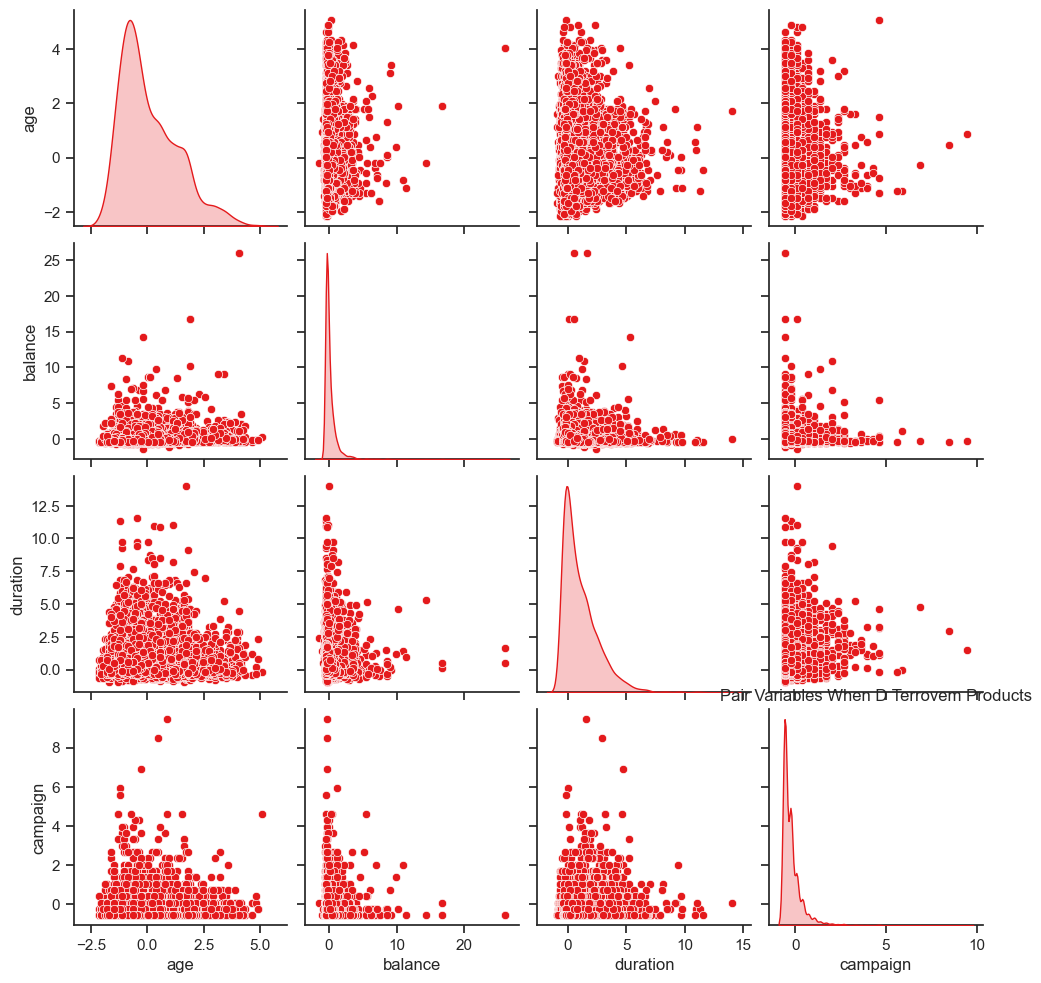

In [515]:
#Chart the relation of age, finance to term products

import seaborn as sns

plt.figure(figsize=(10,6))
sns.pairplot(bank[bank['y'] == 1], vars=['age', 'balance', 'duration', 'campaign'], diag_kind='kde')


plt.title('Pair Variables When D Terrovem Products')
plt.show()

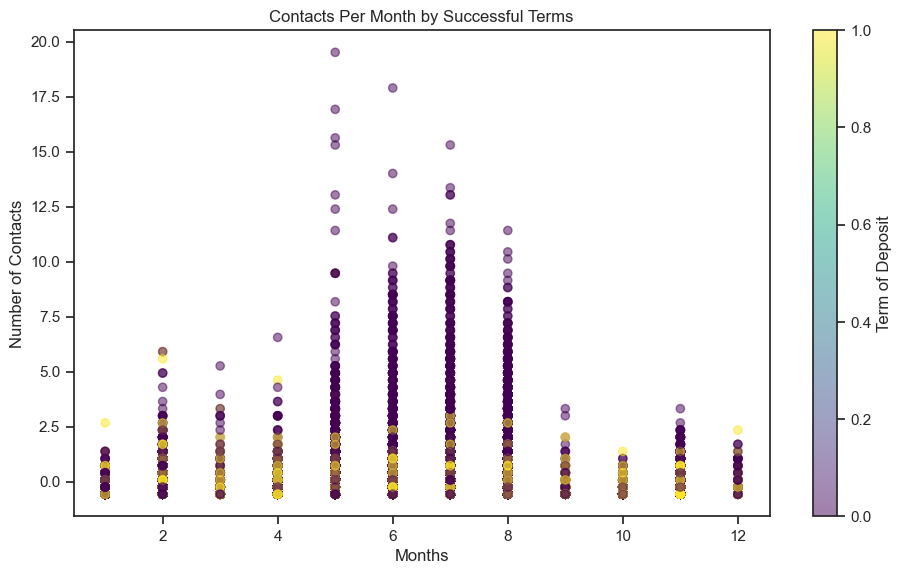

In [521]:
#Plot the difference between the predicted and the actuals


plt.figure(figsize=(10,6))
scatter = plt.scatter(bank['month'], bank['campaign'], c=bank['y'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Term of Deposit')
plt.xlabel('Months')
plt.ylabel('Number of Contacts')
plt.title('Contacts Per Month by Successful Terms')
plt.show()

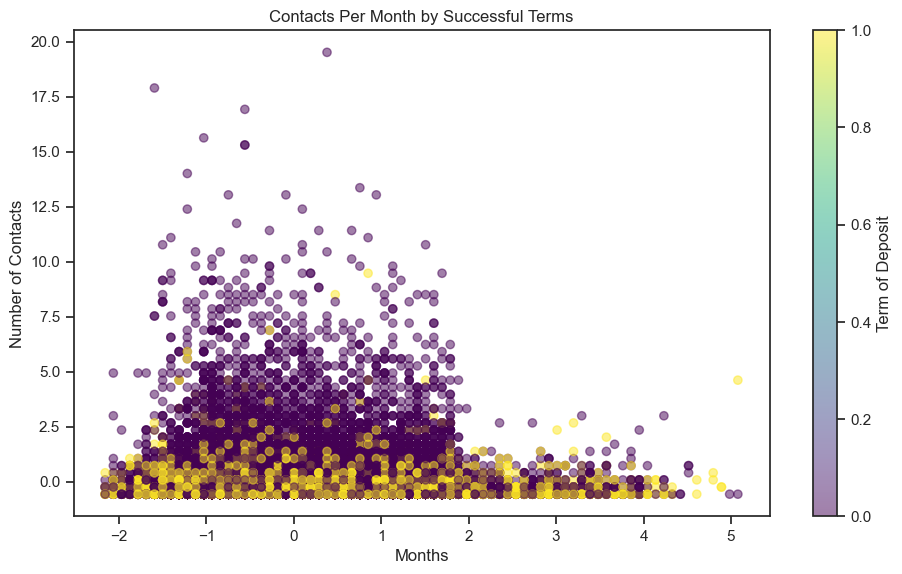

In [523]:
#Plot the difference between the months and number of campaigns


plt.figure(figsize=(10,6))
scatter = plt.scatter(bank['age'], bank['campaign'], c=bank['y'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Term of Deposit')
plt.xlabel('Months')
plt.ylabel('Number of Contacts')
plt.title('Contacts Per Month by Successful Terms')
plt.show()

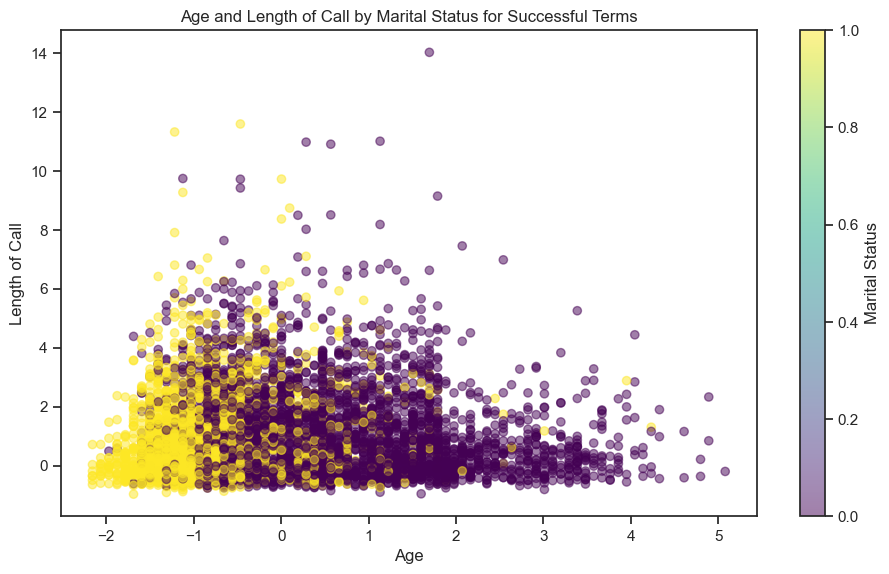

In [525]:
#Plot the difference amongst key variables

termed = bank[bank['y'] == 1]

plt.figure(figsize=(10,6))
scatter = plt.scatter(termed['age'], termed['duration'], c=termed['marital_single'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Marital Status')
plt.xlabel('Age')
plt.ylabel('Length of Call')
plt.title('Age and Length of Call by Marital Status for Successful Terms')
plt.show()

## usiness 

## Recommendations
- Rank and score leads according to the SVM classifier model.  Age and Single Marital status will have the most positive impact. 
- After 2.5 contacts, people stop converting.
- The longer the call duration, the better chance that there will be a conversion, especially with a younger demographic.
- Work with the business to understand why they have so many contacts in the summer months.  With the cap of 2.5 they might concentrate more on the duration of call with younger prospects. 